### Source 
[Here](https://github.com/Xianzhiwang1/CS0451-page-site/tree/main/posts/) is a link to the source code for this blog post.
### Reference
[Here](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-bias-allocative.html#what-you-should-do) is a link to the main guide and reference when we write this blog post.
Another reference is this [paper](https://arxiv.org/pdf/2108.04884.pdf) that documents which variable means what in the PUMS data set we are going to use.  
### Introduction.
From the PUMS official website, we can learn all we want about the PUMS data. The American Community Survey (ACS) Public Use Microdata Sample (PUMS) files are data about individual people and housing units. There are two types of PUMS files, one for Person records and one for Housing Unit records. Each record in the Person file represents a single person. Individuals are organized into households. PUMS files for an individual year contain data on approximately one percent of the United States population. 

In this blog post, we are going to focus on PUMS data on Indiana in 2018. The reason we pick Indiana is that we want to work with a state with a smallish population size, so that it would be easier to download this data using `folktables` to our local machine and work with it. Why not pick Illinois, one might have asked. Anyway, it's kind of random, the author admits.

To be specific, we would like to use this data and models such as logistic regression to predict whether someone is employed or not in Indiana in 2018. Then, we would like to investigate whether the prediction given by our model is racially biased. 

### Implementation 
After introducing the data, we would like to implement some standard machine learning model such as logitic regression from `sklearn`, and investigate any bias that might arise in machine learning predictions. Our main tool will be confusion matrix from `sklearn.metrics`.


In [2]:
%load_ext autoreload
%autoreload 2

First, let's import some libraries that we need.

In [44]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings

# Getting the data using `folktables`

The first thing we do is download the PUMS data for Indiana in 2018 using `folktables`. This allows us to conveniently write a few lines of code and pull the data set from the internet without firing up a browser. After getting the data, we store the data in the variable `acs_data`, and let us take a look at the dataframe using `.head()` function. 

In [5]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter

STATE = "IN"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

In [6]:
acs_data.head(3)

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000042,3,1,2000,2,18,1013097,46,20,...,7,6,82,44,6,76,83,44,45,44
1,P,2018GQ0000053,3,1,2306,2,18,1013097,19,48,...,16,19,37,23,2,19,2,2,40,18
2,P,2018GQ0000074,3,1,2000,2,18,1013097,88,20,...,166,158,160,90,87,84,88,90,13,166


We see that we have $286$ columns, which is more than what we need! Later in the code, we'll select a dozen columns that we need and stick to working with those. However, before jumping into fitting the model, let us first recall how logistic regression works on a high level and what does each column in our data represent. 

# Data wrangling, applying Logistic Regression 
We recall the equation for a linear regression first:
$$ y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n, $$
where, $\beta_i$'s are coefficients, $y$ is the depedent variable, and the $X_i$'s are regressors (independent variables). Now, we recall logistic function (or sigmoid function), which is 
$$ f(x) = \frac{1}{1+e^{-x}}, $$
and when we put those two piece together, we obtain the formula for logistic regression:
$$ y = \frac{1}{1+e^{\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n}}, $$ 
        





Here are the columns/variables that are important for our analysis:
* `PINCP` is total personal income.
* `ESR` is employment status coded as a dummy variable (`1` if employed, `0` if not) 
* `SEX` is binary sex, coded `1` for male, and `2` for female.
* `RAC1P` is race (`1`for White Alone, `2` for Black/African American alone, `3` and above for other self-identified racial groups)
* `DEAR`, `DEYE`, and `DERM` refers to disability status relating to ear, eye, etc.
* `AGEP` is Age, represented as integers.
* `SCHL` is educational attainment, coded as integers.
* `MAR` is Marital status, coded using integers.
* `RELP` is Relationship.
* `COW` is class of worker, coded using integers.
* `OCCP` is occupation.
* `POBP` is place of birth.
* `WKHP` is usual hours worked per week in the past 12 months.  

Since we will devide the data set into racial groups and take a look at racial bias, let's record the encoding of this categorial variable `RAC1P` here for easy reference.
* $1$: White alone
* $2$: Black or African American alone
* $3$: American Indian alone
* $4$: Alaska Native alone
* $5$: American Indian and Alaska Native tribes specified, or American Indian or Alaska Native
* $6$: Asian alone
* $7$: Native Hawaiian and Other Pacific Islander alone
* $8$: Some Other Race alone
* $9$: Two or More Races


<p>We would like to work on the following tasks:</p>

<li>Train a machine learning algorithm to predict whether someone is currently employed, based on their other attributes <em>not</em> including race, and</li>
<li>Perform a bias audit of our algorithm to determine whether it displays racial bias.</li>


In [7]:
my_features=['PINCP', 'ESR', 'AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']
# new_df = acs_data[my_features]
# new_df['INCOME'] = np.where(new_df['PINCP'] >= 70000, 1, 0)
# new_df.loc[new_df['PINCP'] >= 70000]
# new_df.loc[new_df['ESR'] == 1]

Now we form the list `features_to_use`, where we exclude `ESR`, since that is employment status, which is something we want to predict, and also `RAC1P`, which is categorial variable coded in integers for race, and we would like to single this out for the `group` variable in the later code blocks.

In [9]:
features_to_use = [f for f in my_features if f not in ["ESR", "RAC1P"]]

In [10]:
print(features_to_use)

['PINCP', 'AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX']


In [11]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    # group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

Now we could form our training data and testing data.

In [12]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Working with `pd.DataFrame`, apply logistic regression in Python with scikit-learn.
We see that after selecting only the columns we need, we get a smaller data set that is ready for some analysis. Let us turn our data back into a `pd.DataFrame`, which would enable us to use readily avaiable functions from `pandas` library.

In [35]:
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train
# df.loc[df['group'] == 2]
df.head(3)

,PINCP,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,0.0,31.0,20.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,1,False
1,32000.0,50.0,18.0,5.0,0.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,1,True
2,0.0,2.0,0.0,5.0,2.0,2.0,5.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,0.0,1.0,1,False


### Basic Discriptives

Using this data frame, we first answer the following questions:

* How many individuals are in the data?
* Of these individuals, what proportion have target label equal to 1? In employment prediction, these would correspond to employed individuals.
* Of these individuals, how many are in each of the groups?
* In each group, what proportion of individuals have target label equal to 1?
* Check for intersectional trends by studying the proportion of positive target labels broken out by your chosen group labels and an additional group label. For example, if you chose race (RAC1P) as your group, then you could also choose sex (SEX) and compute the proportion of positive labels by both race and sex. This might be a good opportunity to use a visualization such as a bar chart, e.g. via the seaborn package.

First, let us try to compute these values without the help of `groupby()`.

In [15]:
print(f"The Number of Rows is: {df.shape[0]}")
print(f"The Number of Columns is: {df.shape[1]}")
print(f"The Number of individual who are employed is: {df.loc[df['label'] == True].shape[0]}")
print(f"The Percentage of individuals who are employed is: {24858/54144}")
###
print(f"The Number of person who identify as black is: {df.loc[df['group']==2].shape[0]}")
print(f"The Number of person who identify as white is: {df.loc[df['group']==1].shape[0]}")
print(f"The Number of person who identify as black and is currently employed: {df.loc[(df['group']==2) & (df['label']==True)].shape[0]}")
print(f"The Number of person who identify as white and is currently employed: {df.loc[(df['group']==1) & (df['label']==True)].shape[0]}")
###
print(f"The Number of person who identify as other racial groups is: {df.loc[df['group']>= 3].shape[0]}")
print(f"The Number of person who identify as other racial groups and is currently employed: {df.loc[(df['group']>= 3) & (df['label']==True)].shape[0]}")
###
print(f"The Percentage of person who identify as black and is also employed is: {1374/3626}")
print(f"The Percentage of person who identify as white and is also employed is: {22200/47332}")
print(f"The Percentage of person who identify as other racial groups and is also employed is: {1284/3186}")

The Number of Rows is: 54144
The Number of Columns is: 18
The Number of individual who are employed is: 24858
The Percentage of individuals who are employed is: 0.4591090425531915
The Number of person who identify as black is: 3626
The Number of person who identify as white is: 47332
The Number of person who identify as black and is currently employed: 1374
The Number of person who identify as white and is currently employed: 22200
The Number of person who identify as other racial groups is: 3186
The Number of person who identify as other racial groups and is currently employed: 1284
The Percentage of person who identify as black and is also employed is: 0.3789299503585218
The Percentage of person who identify as white and is also employed is: 0.4690272965435646
The Percentage of person who identify as other racial groups and is also employed is: 0.4030131826741996


We see that this is not the most efficient way to compute these values. Hence, let us use `groupby()` and other similar functions that will make our life much easier.

In [16]:
print( df.groupby("SEX").size() )

SEX
1.0    26578
2.0    27566
dtype: int64


We observe that there are $26578$ males and $27566$ females in the data set.
Using the `.groupby` function, we see that we can more efficiently obtain the information we needed than the methods demonstrated in the above cell blocks. 

In [17]:
print( df.groupby("group").size() )

group
1    47332
2     3626
3       83
4        1
5       29
6      942
7       17
8      906
9     1208
dtype: int64


Since `group 1` denotes white individuals, and `group 2` denotes black individuals, we could read off of the previous block of code that there are $47332$ white individuals and $3636$ black individuals in Indiana in 2018.

In [18]:
print(df.groupby("label").size())

label
False    29286
True     24858
dtype: int64


We see that in Indiana in 2018, there's $29286$ persons who are unemployed, and there's $24858$ persons who are employed. Again, using `.groupby` is much more efficient than what we did previously. The total number of persons in the data set is $54144.$ The (average) percentage of individuals who are employed is about $46$ percent.

In [19]:
print(df.groupby(['group', 'label']).size())
print("the average employment rate (of all people in all groups, in Indiana, in 2018) is: " , df["label"].mean())


group  label
1      False    25132
       True     22200
2      False     2252
       True      1374
3      False       50
       True        33
4      True         1
5      False       17
       True        12
6      False      492
       True       450
7      False        6
       True        11
8      False      516
       True       390
9      False      821
       True       387
dtype: int64
the average employment rate (of all people in all groups, in Indiana, in 2018) is:  0.4591090425531915


We see that in `group 1`, for white individuals in Indiana, in 2018, the number of unemployed individual is $25132$, and the number of employed individual is $22200$. Similarly, for black individuals in Indiana, in 2018, the number of unemployed individual is $2252$, and the number of employed individual is $1374$. However, it might be more clear to see the employment rate for better comparison. The following line of code shows the employment rate for each group. The employment rate for white individual in IN in 2018 is $47$ percent. The employment for black individual in IN in 2018 is $37.9$ percent. Hence, we see that the employment rate is higher for a white individual than a black individual statistically. Also, we see that there is only one person in `group 4`, which is Alaska Native. Since there is only one person in this group, we should not be too surprised if we see that the employment rate for this group is $100$ percent, since this just means this one person is employed. 


In [20]:
print( df.groupby("group")["label"].mean() )

group
1    0.469027
2    0.378930
3    0.397590
4    1.000000
5    0.413793
6    0.477707
7    0.647059
8    0.430464
9    0.320364
Name: label, dtype: float64


More efficiently, we could use the following line of code and read off the employment rate for persons based on their race and gender binary. We see that for people identifying as white male, the employment rate is $50.7$ percent. For people identifying as white female, the employment rate is $43.2$ percent.
Similarly, we see that for people identifying as black male, the employment rate is $35.7$ percent. For people identifying as black female, the employment rate is $40$ percent.

In [21]:
df.groupby(["group","SEX"])["label"].mean()

group  SEX
1      1.0    0.507493
       2.0    0.431978
2      1.0    0.357579
       2.0    0.400000
3      1.0    0.348837
       2.0    0.450000
4      2.0    1.000000
5      1.0    0.352941
       2.0    0.500000
6      1.0    0.510067
       2.0    0.448485
7      1.0    0.666667
       2.0    0.625000
8      1.0    0.475877
       2.0    0.384444
9      1.0    0.312178
       2.0    0.328000
Name: label, dtype: float64

The below graph shows the number of female in each racial group and male in each racial group for the PUMS data of Indiana in 2018. Recall that `group 1`, shown in blue here, denotes white individuals, and `group 2`, shown in orange here, denotes black individuals. The rest of the groups denotes several other racial groups, and the detailed encoding could be accessed on PUMS website. The main takaway here is that the population in Indiana in 2018 is predominantly white. 

[Text(0.5, 1.0, 'Bar Plot of number of female and male in each racial group')]

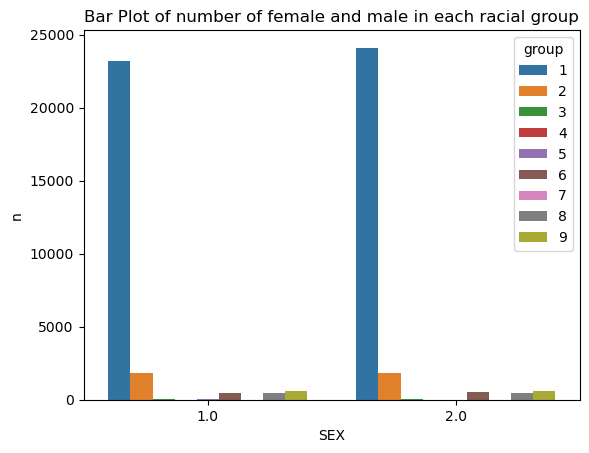

In [36]:
counts = df.groupby(["group", "SEX"]).size().reset_index(name = "n")
sns.barplot(data = counts, x = "SEX", y = "n", hue = "group").set(title="Bar Plot of number of female and male in each racial group")

In the following cell, we show a bar graph of average employment rate for individuals in different racial and gender binary categories. We should ignore `group 4`, which is Alaska Native, since previously, as we are tallying the number of individuals in each racial group, we see that there is only one person in `group 4`, and that person is also recorded as employed, so `group 4` female has a employment rate of $100$ percent is because there's only one person who is also employed.

[Text(0.5, 1.0, 'Bar Plot of average employment rate for female and male individuals in each racial categories')]

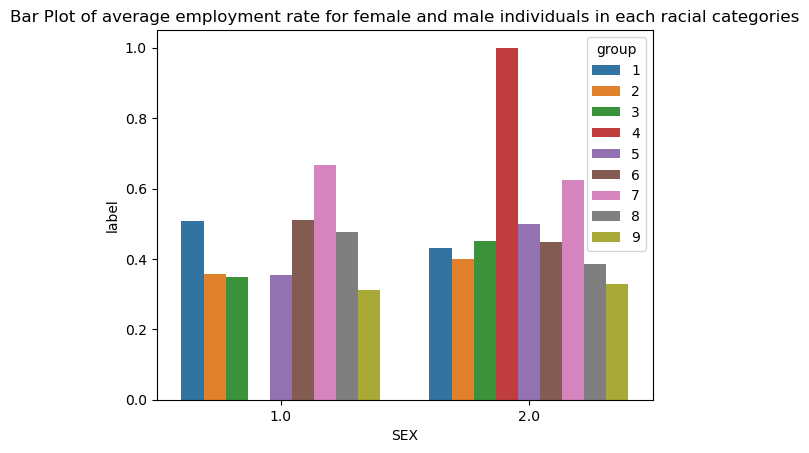

In [37]:

percentages = df.groupby(["group", "SEX"])["label"].mean().reset_index()
sns.barplot(data = percentages, x = "SEX", y = "label", hue = "group").set(title="Bar Plot of average employment rate for female and male individuals in each racial categories")

# Moving on to fitting models
## fit a logistic regression model
After consideration, we decide to go with logistic regression. We build our model, and we fit our model on our training data, which is stored in variable `X_train`, and `y_train`. 

In [24]:
# model = make_pipeline(StandardScaler(), LogisticRegression())
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [42]:
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)
print(f"The overall training score is: {round(train_score,3)} for logistic regression with solver equal to liblinear")
print(f"The overall testing score is: {round(test_score, 3)} for logistic regression with solver equal to liblinear")

The overall training score is: 0.84 for logistic regression with solver equal to liblinear
The overall testing score is: 0.833 for logistic regression with solver equal to liblinear


In [100]:
y_hat = model.predict(X_test)
print(f" The overall testing accuracy in predicting whether someone is employed in 2018 in Indiana is: {(y_hat == y_test).mean()}", "\n",
    f" The accuracy for white individuals is {(y_hat == y_test)[group_test == 1].mean()}", "\n", 
    f" The accuracy for black individuals is {(y_hat == y_test)[group_test == 2].mean()}")
print(f" Classification Report:\n{classification_report(y_test, y_hat)}")

 The overall testing accuracy in predicting whether someone is employed in 2018 in Indiana is: 0.8331855791962175 
  The accuracy for white individuals is 0.8338424983027835 
  The accuracy for black individuals is 0.8265086206896551
 Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.89      0.85      7277
        True       0.86      0.77      0.81      6259

    accuracy                           0.83     13536
   macro avg       0.84      0.83      0.83     13536
weighted avg       0.83      0.83      0.83     13536



##### Cross Validation for Logistic Regression

In [52]:
# cross validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"the cross validation scores are: {cv_scores}")
cv_average = cv_scores.mean()
print(f"the average score for cross validation is: {round(cv_average,3)}")

the cross validation scores are: [0.83876628 0.83876628 0.83830455 0.84246006 0.8405061 ]
the average score for cross validation is: 0.84


### Logistic Regression with Polynomial Features

In [82]:
plr = PolynomialFeatures(degree=2, include_bias=False)
poly_feature = plr.fit_transform(X_train)

By using `fit_transform()`, we have fitted and transformed our traing data `X_train`. We also created the square of the numbers, since we have set the degree to $2$. We could print out the shapes of `poly_feature` and `X_train` for comparison.

In [83]:
print(poly_feature.shape, X_train.shape)

(54144, 152) (54144, 16)


In [84]:
LR_poly = LogisticRegression()
LR_poly.fit(poly_feature, y_train)

LogisticRegression()

In [92]:
print(f"The training score is: {LR_poly.score(poly_feature, y_train)}")
y_hat_poly = LR_poly.predict(poly_feature)
score = (y_hat_poly == y_train).mean()
print(f" The overall training accuracy for polynomial features to predict whether someone is employed in 2018 in Indiana is: {round(score, 3)}")
print(f" Classification Report:\n{classification_report(y_train, y_hat_poly)}")

The training score is: 0.7287603427895981
 The overall training accuracy for polynomial features to predict whether someone is employed in 2018 in Indiana is: 0.729
 Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.50      0.67     29286
        True       0.63      1.00      0.77     24858

    accuracy                           0.73     54144
   macro avg       0.81      0.75      0.72     54144
weighted avg       0.83      0.73      0.71     54144



##### Cross Validation for Polynomial Features Logistic Regression

In [99]:
# cross validation
with warnings.catch_warnings():
    warnings.simplefilter("always")
    warnings.filterwarnings("ignore")
    cv_scores_plr = cross_val_score(LR_poly, X_train, y_train, cv=5)
print(f"\nthe cross validation scores for degree two polynomial logistic regression are: {cv_scores_plr}")
cv_average_plr = cv_scores_plr.mean()
print(f"the average score for cross validation is: {round(cv_average_plr,3)} for degree two polynomial logistic regression\n")


the cross validation scores for degree two polynomial logistic regression are: [0.83313325 0.83830455 0.82814664 0.82500693 0.83053195]
the average score for cross validation is: 0.831 for degree two polynomial logistic regression



## Fit a `DecisionTreeClassifier` model 
Now, let us fit another model.

In [46]:
decisiontree = DecisionTreeClassifier(max_depth=5,
                       splitter="best",
                        max_features=None,
                         random_state=None,
                          max_leaf_nodes=None,
                           class_weight=None)
decisiontree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

Now we score our Decision Tree Classifier on the test sets, and we could read off the overall test score as $0.833$.

In [47]:
train_score_dt = decisiontree.score(X_train,y_train)
test_score_dt = decisiontree.score(X_test,y_test)

print(f"The overall training score is: {round(train_score_dt,3)} for Decision Tree Classifier with max_depth equals 5")
print(f"The overall testing score is: {round(test_score_dt, 3)} for Decision Tree Classifier with max_depth equals 5")

The overall training score is: 0.886 for Decision Tree Classifier with max_depth equals 5
The overall testing score is: 0.884 for Decision Tree Classifier with max_depth equals 5


##### Cross Validation for Decision Tree Classifier

In [54]:
# cross validation
cv_scores_df = cross_val_score(decisiontree, X_train, y_train, cv=5)
print(f"the cross validation scores are: {cv_scores_df}")
cv_average_df = cv_scores_df.mean()
print(f"the average score for cross validation is: {round(cv_average_df,3)}")

the cross validation scores are: [0.88170653 0.88854003 0.8847539  0.88262998 0.88520502]
the average score for cross validation is: 0.885


##### Tuning `DecisionTreeClassifier`

In [62]:

decisiontree2 = DecisionTreeClassifier(max_depth=None,
                       splitter="best",
                        max_features=None,
                         random_state=None,
                          max_leaf_nodes=None,
                           class_weight=None)
decisiontree2.fit(X_train, y_train)

DecisionTreeClassifier()

In [63]:
train_score_dt = decisiontree.score(X_train,y_train)
test_score_dt = decisiontree.score(X_test,y_test)
print(f"The overall training score is: {round(train_score_dt,3)} for Decision Tree Classifier with max_depth equals 5")
print(f"The overall testing score is: {round(test_score_dt, 3)} for Decision Tree Classifier with max_depth equals 5")
# cross validation
cv_scores_df = cross_val_score(decisiontree, X_train, y_train, cv=5)
print(f"the cross validation scores are: {cv_scores_df}")
cv_average_df = cv_scores_df.mean()
print(f"the average score for cross validation is: {round(cv_average_df,3)}")

The overall training score is: 0.886 for Decision Tree Classifier with max_depth equals 5
The overall testing score is: 0.884 for Decision Tree Classifier with max_depth equals 5
the cross validation scores are: [0.88170653 0.88854003 0.8847539  0.88262998 0.88520502]
the average score for cross validation is: 0.885


# Audit the model
We seek to answer the following questions using the Logistic Regression `model` we fitted earlier. We will only focus on testing data.

### Overall Measures
* What is the overall accuracy of your model?
* What is the positive predictive value (PPV) of your model?
* What are the overall false negative and false positive rates (FNR and FPR) for your model?
### By-Group Measures
* What is the accuracy of your model on each subgroup?
* What is the PPV of your model on each subgroup?
* What are the FNR and FPR on each subgroup?
### Bias Measures
* See Chouldechova (2017) for definitions of these terms. For calibration, you can think of the score as having only two values, 0 and 1.
* Is your model approximately calibrated?
* Does your model satisfy approximate error rate balance?
* Does your model satisfy statistical parity?

In [102]:
for obj in [features, label, group]:
  print(obj.shape)

(67680, 16)
(67680,)
(67680,)


In [103]:
print(model.score(X_test,y_test))

0.8331855791962175


Hence, the score for logistic regression is $8.33$, which is not bad!

In [109]:
my_matr = confusion_matrix(y_test, model.predict(X_test))
print(f"confusion matrix is:\n{my_matr}")

confusion matrix is:
[[6465  812]
 [1446 4813]]


The positive predictive value (PPV) is obtained by using this formula: $$PPV = \frac{TP}{TP+FP},$$ where $TP$ denotes True Positive, and $FP$ denotes True Negative. Hence, we need the value from lower-right corner (TP) of the confusion matrix divided by the value from lower right corner (TP) plus upper-right corner (FP). 

In [107]:
print(f"The positive predictive value for logistic regression is {round(4813/(4813+812), 3)}")

The positive predictive value for logistic regression is 0.856


Recall that:
* upper-left corner is `TN`, which stands for `True negative`
* lower-left corner is `FN`, `False negative` 
* upper-right corner is `FP`, which stands for `False positive`
* lower-right corner is `TP`, `True positive` 

$$
\begin{bmatrix}
TN & FP\\
FN & TP\\
\end{bmatrix}
$$

We also care about the `FPR`, which stands for the false positive rate, which is top-right corner of the confusion matrix (after we normalize).  `FNR` is false negative rate.

In [111]:
my_matr = confusion_matrix(y_test, model.predict(X_test), normalize="true")
print(f"Normalized confusion matrix is:\n{my_matr}")

Normalized confusion matrix is:
[[0.88841556 0.11158444]
 [0.23102732 0.76897268]]


FPR is $0.111$, FNR is $0.231$. We see that FNR is twice the amount of FPR, which means this model is twice as likely to produce False negative as it is to produce false positive. In plain english, this model is twice as likely to predict someone not have a job while that person actually have a job, than the other way round.
### Plot the confusion matrix in colors

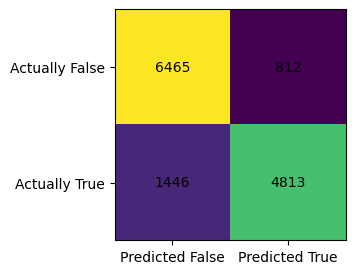

In [113]:
my_matr = confusion_matrix(y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(my_matr)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted False', 'Predicted True'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actually False', 'Actually True'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j,i, my_matr[i,j], ha='center', va='center', color='black')

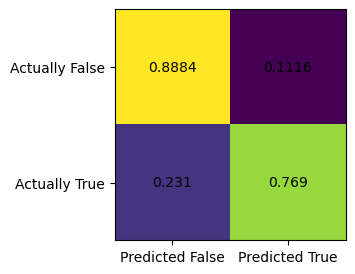

In [114]:

my_matr = confusion_matrix(y_test, model.predict(X_test), normalize="true")
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(my_matr)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted False', 'Predicted True'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actually False', 'Actually True'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j,i, my_matr[i,j].round(4), ha='center', va='center', color='black')

### By-group measures

In [127]:
df_test = pd.DataFrame(X_test, columns = features_to_use)
df_test["group"] = group_test
df_test["label"] = y_test
# df.loc[df['group'] == 2]
df_test.head(3)

,PINCP,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,12000.0,59.0,17.0,3.0,10.0,2.0,0.0,1.0,1.0,4.0,3.0,1.0,2.0,2.0,2.0,2.0,1,False
1,369000.0,57.0,16.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,True
2,34000.0,27.0,19.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,1,True


In [120]:
y_hat=model.predict(X_test)
print(f" The accuracy for white individuals is {(y_hat == y_test)[group_test == 1].mean()}", "\n", 
    f" The accuracy for black individuals is {(y_hat == y_test)[group_test == 2].mean()}")

 The accuracy for white individuals is 0.8338424983027835 
  The accuracy for black individuals is 0.8265086206896551


In [141]:
black_indicator = df_test["group"]==2
white_indicator = df_test["group"]==1
y_test_black = df_test["label"][black_indicator]
X_test_black = df_test.drop(["group","label"], axis=1)[black_indicator]
y_test_white = df_test["label"][white_indicator]
X_test_white = df_test.drop(["group","label"], axis=1)[white_indicator]

with warnings.catch_warnings():
    warnings.simplefilter("always")
    warnings.filterwarnings("ignore")
    y_hat_black = model.predict(X_test_black)
    my_matr = confusion_matrix(y_test_black, y_hat_black)
    print(f"confusion matrix when we restrict to black individual is:\n{my_matr}")

    y_hat_white = model.predict(X_test_white)
    my_matr = confusion_matrix(y_test_white, y_hat_white)
    print(f"confusion matrix when we restrict to white individual is:\n{my_matr}")

    y_hat_black = model.predict(X_test_black)
    my_matr = confusion_matrix(y_test_black, y_hat_black, normalize="true")
    print(f"normalized confusion matrix when we restrict to black individual is:\n{my_matr}")

    y_hat_white = model.predict(X_test_white)
    my_matr = confusion_matrix(y_test_white, y_hat_white, normalize="true")
    print(f"normalized confusion matrix when we restrict to white individual is:\n{my_matr}")

confusion matrix when we restrict to black individual is:
[[513  48]
 [113 254]]
confusion matrix when we restrict to white individual is:
[[5519  719]
 [1239 4307]]
normalized confusion matrix when we restrict to black individual is:
[[0.9144385  0.0855615 ]
 [0.30790191 0.69209809]]
normalized confusion matrix when we restrict to white individual is:
[[0.8847387  0.1152613 ]
 [0.22340426 0.77659574]]


Recall that:
$$
\begin{bmatrix}
TN & FP\\
FN & TP\\
\end{bmatrix}
$$

We also care about the `FPR`, which stands for the false positive rate, which is top-right corner of the confusion matrix (after we normalize).  `FNR` is false negative rate. We see that the FPR when we restrict to black individual is $0.0855$, and the FNR is $0.308$. We see that the model is very unlikely to predict a black individual have a job when they are not actually employed since FPR is so low. On the other hand, the FNR is quite high, the model is very likely to predict a black individual is unemployed, when they are actually employed. 

By contrast, we see that FPR when we restrict to white individual is $0.115$, and the FNR is $0.223$. Compared to black individuals, the model has much more balanced FNR and FPR for white individuals.

In [142]:
X_test_pd = pd.DataFrame(X_test, columns=features_to_use)

We have caliberated Logistic Regression by adding polynomial features. Just at it stands alone, the Logistic Regression we fitted has a high score, but it does not have error rate balance when we restrict to using only data from black individuals. It seems that the model is biased towards predicting black individuals as unemployed. It satisfies the statistical parity to some extent.

### Concluding Discussion
It seems that this Logistic Regression model is biased towards predicting black individuals as unemployed, 